# Data cleaning

Sources for the biased dataset creation :
- https://www.insee.fr/fr/statistiques/7658986
- https://gpseducation.oecd.org/Content/EAGCountryNotes/EAG2023_CN_FRA_pdf.pdf
- https://www.ifpi.org/wp-content/uploads/2020/07/Music-Listening-2019-1.pdf

## Part 1 : Load packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import timedelta, datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import shap
!pip install fairlearn
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.5 MB/s eta 0:00:00


## Part 2 : Import datasets and print the first rows of the datasets

### Spotify song attributes dataset

In [2]:
spotify_song_attributes = pd.read_csv('spotify_song_attributes.csv')
spotify_song_attributes = spotify_song_attributes.drop_duplicates()
spotify_song_attributes = spotify_song_attributes[spotify_song_attributes['genre'] != 'meme']

# Dataset adjustment : create a "main_genre" variable to regroup the genres of a same category together
genre_mapping = {
    'Pop': ['pop', 'dance pop', 'electropop', 'indie pop', 'art pop', 'metropopolis', 'shimmer pop', 'viral pop'],
    'Rock': ['alternative rock', 'indie rock', 'garage rock', 'classic rock', 'hard rock', 'blues rock', 'christian rock'],
    'Hip-hop': ['hip hop', 'trap', 'conscious hip hop', 'rap', 'cloud rap', 'gangster rap', 'pop rap'],
    'Electronic': ['edm', 'house', 'techno', 'dubstep', 'future bass', 'electro house'],
    'Classical': ['classical', 'baroque', 'orchestral soundtrack'],
    'Jazz': ['jazz rap', 'soul jazz', 'jazz cover'],
    'Indie': ['indie folk', 'folk-pop', 'modern folk rock', 'indie rock', 'indie pop'],
    'Country': ['country', 'contemporary country', 'classic country pop']
}

main_genres = {}
for main_genre, subgenres in genre_mapping.items():
    for subgenre in subgenres:
        main_genres[subgenre] = main_genre

def get_main_genre(genre_str):
    genre_lower = str(genre_str).lower()
    for subgenre, main_genre in main_genres.items():
        if subgenre.lower() in genre_lower:
            return main_genre
    return 'other'

spotify_song_attributes['main_genre'] = spotify_song_attributes['genre'].apply(get_main_genre)
print(spotify_song_attributes.shape)
spotify_song_attributes.head()

(5036, 17)


,track_id,artist_name,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,msPlayed,main_genre
0,7dTxqsaFGHOXwtzHINjfHv,Nico Collins,NaN,0.476,0.799,4.0,-4.939,0.0,0.2120,0.0162,0.000000,0.2570,0.577,162.139,191948.0,191772,other
1,14Qcrx6Dfjvcj0H8oV8oUW,London Symphony Orchestra,british orchestra,0.475,0.130,7.0,-17.719,1.0,0.0510,0.9160,0.956000,0.1010,0.122,112.241,150827.0,1806234,other
2,7K9Z3yFNNLv5kwTjQYGjnu,SyKo,glitchcore,0.691,0.814,1.0,-3.788,0.0,0.1170,0.0164,0.000000,0.3660,0.509,132.012,145611.0,145610,other
3,3koAwrM1RO0TGMeQJ3qt9J,Good Morning,experimental pop,0.624,0.596,4.0,-9.804,1.0,0.0314,0.4750,0.203000,0.1190,0.896,120.969,89509.0,25058,Pop
4,4ByEFOBuLXpCqvO1kw8Wdm,Cutting Crew,album rock,0.625,0.726,11.0,-11.402,0.0,0.0444,0.0158,0.000169,0.0625,0.507,124.945,280400.0,5504949,other


### Unbiased datasets : education_level doesn't influence music taste

In [3]:
# Spotify user infos dataset
unbiased_spotify_user_dataset = pd.read_csv('unbiased_spotify_user_dataset.csv')
print(unbiased_spotify_user_dataset.shape)
unbiased_spotify_user_dataset.head()

(10000, 9)


,user_id,age,gender,education_level,listening_hours,preferred_genres,favorite_artist,discovery_channel,country
0,1,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico
1,2,60,Female,Master's,6.4,Jazz,Miles Davis,Search,Canada
2,3,66,Male,Bachelor's,28.3,Electronic,Kygo,Friend,Germany
3,4,13,Male,PhD,15.4,Pop,Olivia Rodrigo,Social Media,France
4,5,16,Other,PhD,8.8,Electronic,David Guetta,Playlist,Mexico


In [4]:
# Spotify user interactions
unbiased_user_interactions = pd.read_csv('user_interactions.csv')
unbiased_user_interactions = unbiased_user_interactions.drop(columns={'skip'})

def generate_timestamps_for_user(df, min_gap=3, max_gap=30):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    start_date = pd.Timestamp('2025-01-01') + pd.to_timedelta(np.random.randint(0, 60*24*30), unit='m')
    timestamps = [start_date]
    for _ in range(1, len(df)):
        gap = np.random.randint(min_gap, max_gap)
        timestamps.append(timestamps[-1] + timedelta(minutes=gap))
    df['timestamp'] = timestamps
    return df
unbiased_user_interactions = unbiased_user_interactions.groupby('user_id', group_keys=False).apply(generate_timestamps_for_user)

print(unbiased_user_interactions.shape)
unbiased_user_interactions.head()

(499230, 4)


/tmp/ipython-input-988038643.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unbiased_user_interactions = unbiased_user_interactions.groupby('user_id', group_keys=False).apply(generate_timestamps_for_user)


,user_id,track_id,listen_count,timestamp
0,1,1PKqiewc0OyZVYxFz5ugbH,4,2025-01-27 04:59:00
1,1,4Gd6sRU6HvEdWrwQ8xldzk,4,2025-01-27 05:09:00
2,1,1BpFpM2QBsuV7lrRPHiiay,3,2025-01-27 05:28:00
3,1,3fB2jhxOmwMsTxCYpjYjd4,4,2025-01-27 05:54:00
4,1,2jUoKSWTHduXxUL3JomwhB,2,2025-01-27 05:58:00


### Biased datasets : education_level does influence music taste

In [6]:
# Spotify user infos dataset
biased_spotify_user_dataset = pd.read_csv('biased_spotify_user_dataset.csv')
print(biased_spotify_user_dataset.shape)
biased_spotify_user_dataset.head()

(10000, 9)


,user_id,age,gender,education_level,listening_hours,preferred_genres,favorite_artist,discovery_channel,country
0,1,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico
1,2,60,Female,Bachelor's,16.885878,Electronic,Zedd,Search,Canada
2,3,66,Male,Some college,17.487272,Hip-hop,Kendrick Lamar,Friend,Germany
3,4,13,Male,Some college,16.192137,Rock,Green Day,Social Media,France
4,5,16,Other,Bachelor's,25.468328,Pop,Selena Gomez,Playlist,Mexico


In [7]:
# Spotify user interactions dataset
biased_user_interactions = pd.read_csv('biased_user_interactions.csv')
biased_user_interactions = biased_user_interactions.drop(columns=['Unnamed: 0'])
print(biased_user_interactions.shape)
biased_user_interactions.head()

(499230, 4)


,user_id,track_id,listen_count,timestamp
0,1,3NLrRZoMF0Lx6zTlYqeIo4,2,2024-04-06
1,1,3V5PkCdHl3g1w2uiimU0jT,1,2024-07-21
2,1,7aSvPfoqiM0zwPqupLGaHd,2,2024-07-09
3,1,NaN,5,2020-01-18
4,1,3dNEnD700nYq0TY0w6AJjs,5,2022-01-14


## Part 3 : Merge datasets

### Unbiased final dataset

In [8]:
interactions_with_attributes = pd.merge(unbiased_user_interactions,spotify_song_attributes.drop(columns=['msPlayed']),on='track_id',how='left')
unbiased_final_dataset = pd.merge(interactions_with_attributes,unbiased_spotify_user_dataset,on='user_id',how='left')
unbiased_final_dataset.head()

,user_id,track_id,listen_count,timestamp,artist_name,genre,danceability,energy,key,loudness,...,duration_ms,main_genre,age,gender,education_level,listening_hours,preferred_genres,favorite_artist,discovery_channel,country
0,1,1PKqiewc0OyZVYxFz5ugbH,4,2025-01-27 04:59:00,Jonas Blue,pop,0.702,0.75900,0.0,-3.292,...,198408.0,Pop,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico
1,1,4Gd6sRU6HvEdWrwQ8xldzk,4,2025-01-27 05:09:00,London Festival Orchestra Alfred Scholz,british orchestra,0.612,0.00578,2.0,-26.941,...,131893.0,other,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico
2,1,1BpFpM2QBsuV7lrRPHiiay,3,2025-01-27 05:28:00,DJ Lagoa,lo-fi brasileiro,0.473,0.20000,10.0,-16.990,...,134400.0,other,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico
3,1,3fB2jhxOmwMsTxCYpjYjd4,4,2025-01-27 05:54:00,Bhikhari Bala,odia bhajan,0.328,0.57100,1.0,-6.913,...,313748.0,other,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico
4,1,2jUoKSWTHduXxUL3JomwhB,2,2025-01-27 05:58:00,Tove Lo,metropopolis,0.919,0.68700,9.0,-5.793,...,162947.0,Pop,57,Other,Bachelor's,26.9,Pop,Taylor Swift,Concert,Mexico


/tmp/ipython-input-700142262.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_to_export = df_to_export.applymap(truncate_text)


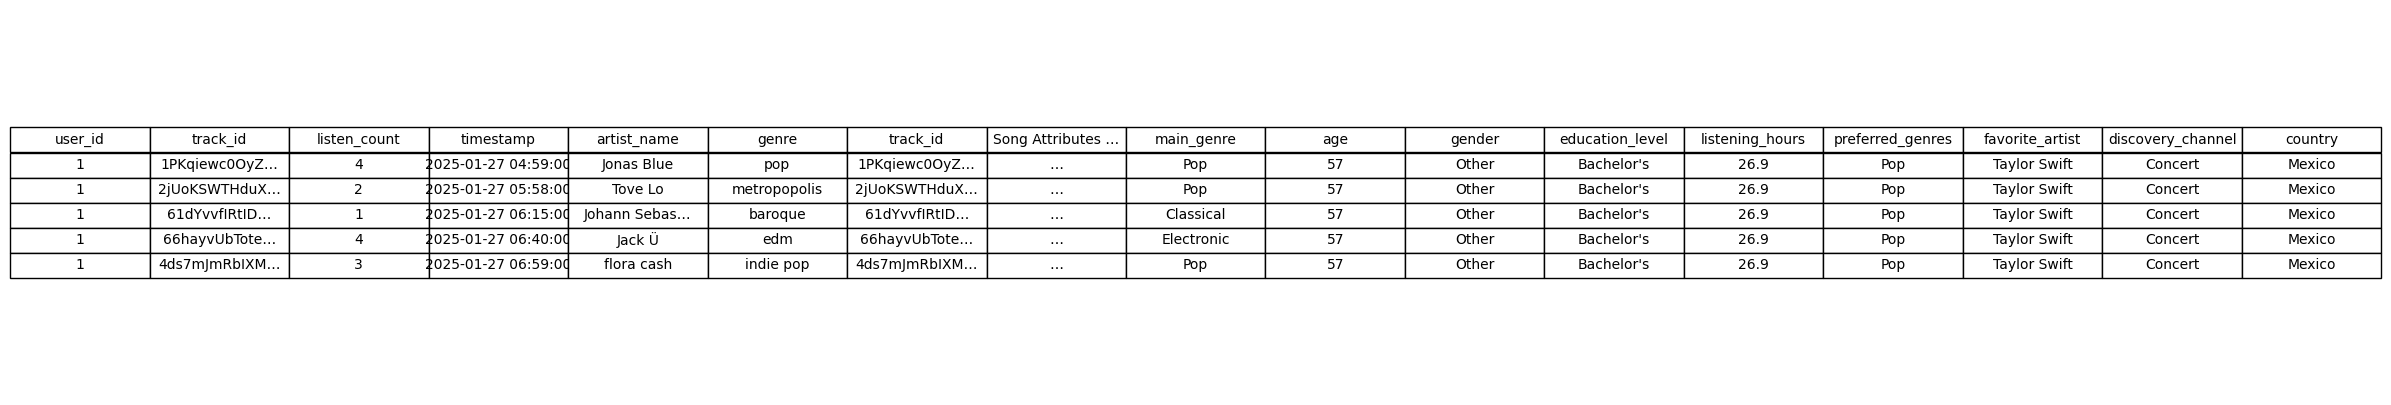

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Fusionner les datasets
interactions_with_attributes = pd.merge(
    unbiased_user_interactions,
    spotify_song_attributes.drop(columns=['msPlayed']),
    on='track_id',
    how='left'
)

unbiased_final_dataset = pd.merge(
    interactions_with_attributes,
    unbiased_spotify_user_dataset,
    on='user_id',
    how='left'
)

# Filtrer les lignes où main_genre != 'other'
df_filtered = unbiased_final_dataset[unbiased_final_dataset['main_genre'] != 'other'].copy()

# Prendre les 5 premières lignes
df_to_export = df_filtered.head(5).copy()

# Tronquer le texte long dans toutes les colonnes pour ne pas dépasser
def truncate_text(x, max_len=12):
    if isinstance(x, str) and len(x) > max_len:
        return x[:max_len] + '…'
    return x

df_to_export = df_to_export.applymap(truncate_text)

# Identifier les colonnes à regrouper dans "Song Attributes …"
cols = df_to_export.columns.tolist()
dance_idx = cols.index('danceability')
duration_idx = cols.index('duration_ms')
song_attr_cols = cols[dance_idx:duration_idx+1]

# Créer la colonne condensée
df_to_export['Song Attributes …'] = '…'

# Colonnes finales : tout avant danceability, track_id, Song Attributes …, reste des colonnes
cols_before = cols[:dance_idx]  # avant danceability
cols_after = [col for col in cols if col not in cols_before + list(song_attr_cols)]
df_final_display = df_to_export[cols_before + ['track_id', 'Song Attributes …'] + cols_after].copy()

# Ajuster la taille de la figure
num_cols = len(df_final_display.columns)
fig_width = max(12, num_cols * 1.5)
fig_height = 2 + 0.6*len(df_final_display)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('off')  # enlever les axes

# Créer le tableau
table = ax.table(
    cellText=df_final_display.values,
    colLabels=df_final_display.columns,
    cellLoc='center',
    loc='center'
)

# Ajuster la police
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Sauvegarder en PNG
plt.savefig("unbiased_final_dataset_head_5rows_filtered.png", bbox_inches='tight', dpi=300)
plt.show()


### Biased final dataset

In [10]:
biased_interactions_with_attributes = pd.merge(biased_user_interactions,spotify_song_attributes.drop(columns=['msPlayed']),on='track_id',how='left')
biased_final_dataset = pd.merge(biased_interactions_with_attributes,biased_spotify_user_dataset,on='user_id',how='left')
biased_final_dataset.head()

,user_id,track_id,listen_count,timestamp,artist_name,genre,danceability,energy,key,loudness,...,duration_ms,main_genre,age,gender,education_level,listening_hours,preferred_genres,favorite_artist,discovery_channel,country
0,1,3NLrRZoMF0Lx6zTlYqeIo4,2,2024-04-06,3 Doors Down,alternative metal,0.557,0.533,10.0,-6.817,...,238733.0,other,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico
1,1,3V5PkCdHl3g1w2uiimU0jT,1,2024-07-21,glaive,glitchcore,0.622,0.790,8.0,-5.664,...,123204.0,other,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico
2,1,7aSvPfoqiM0zwPqupLGaHd,2,2024-07-09,Charlie Puth,pop,0.725,0.770,1.0,-6.240,...,263413.0,Pop,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico
3,1,NaN,5,2020-01-18,NF,NaN,NaN,NaN,NaN,NaN,...,NaN,other,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico
4,1,NaN,5,2020-01-18,Idkconundrum,NaN,NaN,NaN,NaN,NaN,...,NaN,other,57,Other,Bachelor's,20.108202,Electronic,Calvin Harris,Concert,Mexico


### Final datasets description

**Dataset Description**
<br>

Each row in the dataset represents a unique interaction between a user and a song (a user listening to a specific track).

**Variables**

| **Variable**           | **Description**                                                                                 |
| ---------------------- | ----------------------------------------------------------------------------------------------- |
| **user\_id**           | Unique identifier of the user                                                                   |
| **track\_id**          | Unique identifier of the song                                                                   |
| **listen\_count**      | Number of times the user listened to this song                                                  |
| **timestamp**          | Date and time when the user first listened to this song                                         |
| **artist\_name**       | Name of the song’s artist                                                                       |
| **genre**              | Musical genre of the song                                                                       |
| **main\_genre**        | Main category of the musical genre of the song                                                                       |
| **danceability**       | Decimal value indicating how suitable the track is for dancing                                  |
| **energy**             | Decimal value representing the intensity and energy level of the track                          |
| **key**                | Musical key of the track (integer, e.g., 0 = C, 1 = C♯/D♭, etc.)                                |
| **loudness**           | Average loudness in decibels (dB)                                                               |
| **mode**               | Musical mode: 1 for major, 0 for minor                                                          |
| **speechiness**        | Decimal value measuring presence of spoken words                                                |
| **acousticness**       | Decimal value indicating degree of acoustic sound                                               |
| **instrumentalness**   | Decimal value representing likelihood the track is instrumental                                 |
| **liveness**           | Decimal value for probability the track was performed live                                      |
| **valence**            | Decimal value describing musical positivity (happy vs. sad)                                     |
| **tempo**              | Decimal value representing tempo in beats per minute (BPM)                                      |
| **duration\_ms**       | Duration of the track in milliseconds                                                           |
| **age**                | Age of the user                                                                                 |
| **gender**             | Gender of the user                                                                              |
| **education\_level**   | Education level of the user                                                                     |
| **listening\_hours**   | Total number of hours the user spends listening to music on the platform (weekly)               |
| **preferred\_genres**  | User’s preferred music genres                                                                   |
| **favorite\_artist**   | User’s favorite artist                                                                          |
| **discovery\_channel** | How the user mostly discovers new songs (e.g., search, playlist, social media, friend, concert) |
| **country**            | User’s country of residence                                                                     |


## Part 4 : Clean data

In [11]:
# Delete duplicates
unbiased_final_dataset = unbiased_final_dataset.drop_duplicates()
biased_final_dataset = biased_final_dataset.drop_duplicates()

# Delete missing values
unbiased_final_dataset = unbiased_final_dataset.dropna()
biased_final_dataset = biased_final_dataset.dropna()

# Delete outliers
num_cols = unbiased_final_dataset.select_dtypes(include='number').columns
Q1 = unbiased_final_dataset[num_cols].quantile(0.25)
Q3 = unbiased_final_dataset[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = unbiased_final_dataset[
    ((unbiased_final_dataset[num_cols] < (Q1 - 1.5 * IQR)) |
     (unbiased_final_dataset[num_cols] > (Q3 + 1.5 * IQR))
    ).any(axis=1)
]

num_cols = biased_final_dataset.select_dtypes(include='number').columns
Q1 = biased_final_dataset[num_cols].quantile(0.25)
Q3 = biased_final_dataset[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = biased_final_dataset[
    ((biased_final_dataset[num_cols] < (Q1 - 1.5 * IQR)) |
     (biased_final_dataset[num_cols] > (Q3 + 1.5 * IQR))
    ).any(axis=1)
]

In [12]:
print(f"\nUnbiased final dataset shape : {unbiased_final_dataset.shape}")
print(f"\nBiased final dataset shape : {biased_final_dataset.shape}")


Unbiased final dataset shape : (424538, 27)

Biased final dataset shape : (424903, 27)


## Part 5 : Exploratory Data Analysis

In [13]:
unbiased_final_dataset.describe()

,user_id,listen_count,timestamp,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,age,listening_hours
count,424538.000000,424538.000000,424538,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,424538.000000,4.245380e+05,424538.000000,424538.000000
mean,5001.024679,3.003072,2025-01-16 03:11:24.469752832,0.602364,0.567232,5.241451,-8.571224,0.617523,0.078637,0.357409,0.149431,0.174733,0.436118,119.151352,2.038979e+05,41.031660,22.662154
min,1.000000,1.000000,2025-01-01 00:18:00,0.000000,0.001080,0.000000,-42.044000,0.000000,0.000000,0.000002,0.000000,0.024900,0.000000,0.000000,1.002700e+04,13.000000,5.000000
25%,2500.000000,2.000000,2025-01-08 16:02:00,0.508000,0.408000,2.000000,-10.004000,0.000000,0.036200,0.051400,0.000000,0.096000,0.239000,97.236000,1.629150e+05,27.000000,13.900000
50%,5005.000000,3.000000,2025-01-16 00:33:00,0.624000,0.592000,5.000000,-7.117000,1.000000,0.048200,0.239000,0.000024,0.120000,0.411000,118.998000,1.959520e+05,41.000000,22.700000
75%,7501.000000,4.000000,2025-01-23 15:22:00,0.715000,0.754000,8.000000,-5.312000,1.000000,0.082200,0.656750,0.023500,0.210000,0.618000,139.324000,2.310020e+05,55.000000,31.400000
max,10000.000000,12.000000,2025-01-31 17:02:00,0.965000,0.999000,11.000000,3.010000,1.000000,0.941000,0.996000,0.993000,0.964000,0.986000,236.196000,1.847210e+06,69.000000,40.000000
std,2888.465674,1.413804,NaN,0.158265,0.241762,3.575556,5.322580,0.485993,0.078962,0.332840,0.309907,0.130746,0.242583,28.943833,7.417905e+04,16.413253,10.110654


In [14]:
biased_final_dataset.describe()

,user_id,listen_count,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,age,listening_hours
count,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,424903.000000,4.249030e+05,424903.000000,424903.000000
mean,4998.595762,3.069494,0.601588,0.566086,5.248396,-8.591917,0.616117,0.078163,0.359228,0.149320,0.174485,0.435624,119.124345,2.038656e+05,40.988007,19.232441
std,2885.795355,1.705623,0.158695,0.241756,3.574966,5.325693,0.486331,0.078292,0.333008,0.309720,0.130663,0.243132,28.935008,7.348532e+04,16.410497,5.656132
min,1.000000,1.000000,0.000000,0.001080,0.000000,-42.044000,0.000000,0.000000,0.000002,0.000000,0.024900,0.000000,0.000000,1.002700e+04,13.000000,1.000000
25%,2499.000000,2.000000,0.507000,0.407000,2.000000,-10.045000,0.000000,0.036100,0.052600,0.000000,0.095900,0.238000,97.133000,1.628640e+05,27.000000,15.227396
50%,4998.000000,3.000000,0.623000,0.591000,5.000000,-7.142000,1.000000,0.047900,0.241000,0.000024,0.120000,0.410000,118.962000,1.958930e+05,41.000000,18.912237
75%,7498.000000,4.000000,0.715000,0.752000,8.000000,-5.322000,1.000000,0.081400,0.660000,0.023900,0.209000,0.618000,139.432000,2.312130e+05,55.000000,22.913510
max,10000.000000,22.000000,0.965000,0.999000,11.000000,3.010000,1.000000,0.941000,0.996000,0.993000,0.964000,0.986000,236.196000,1.847210e+06,69.000000,42.585860


### Dataset visualisation

#### Unbiased dataset

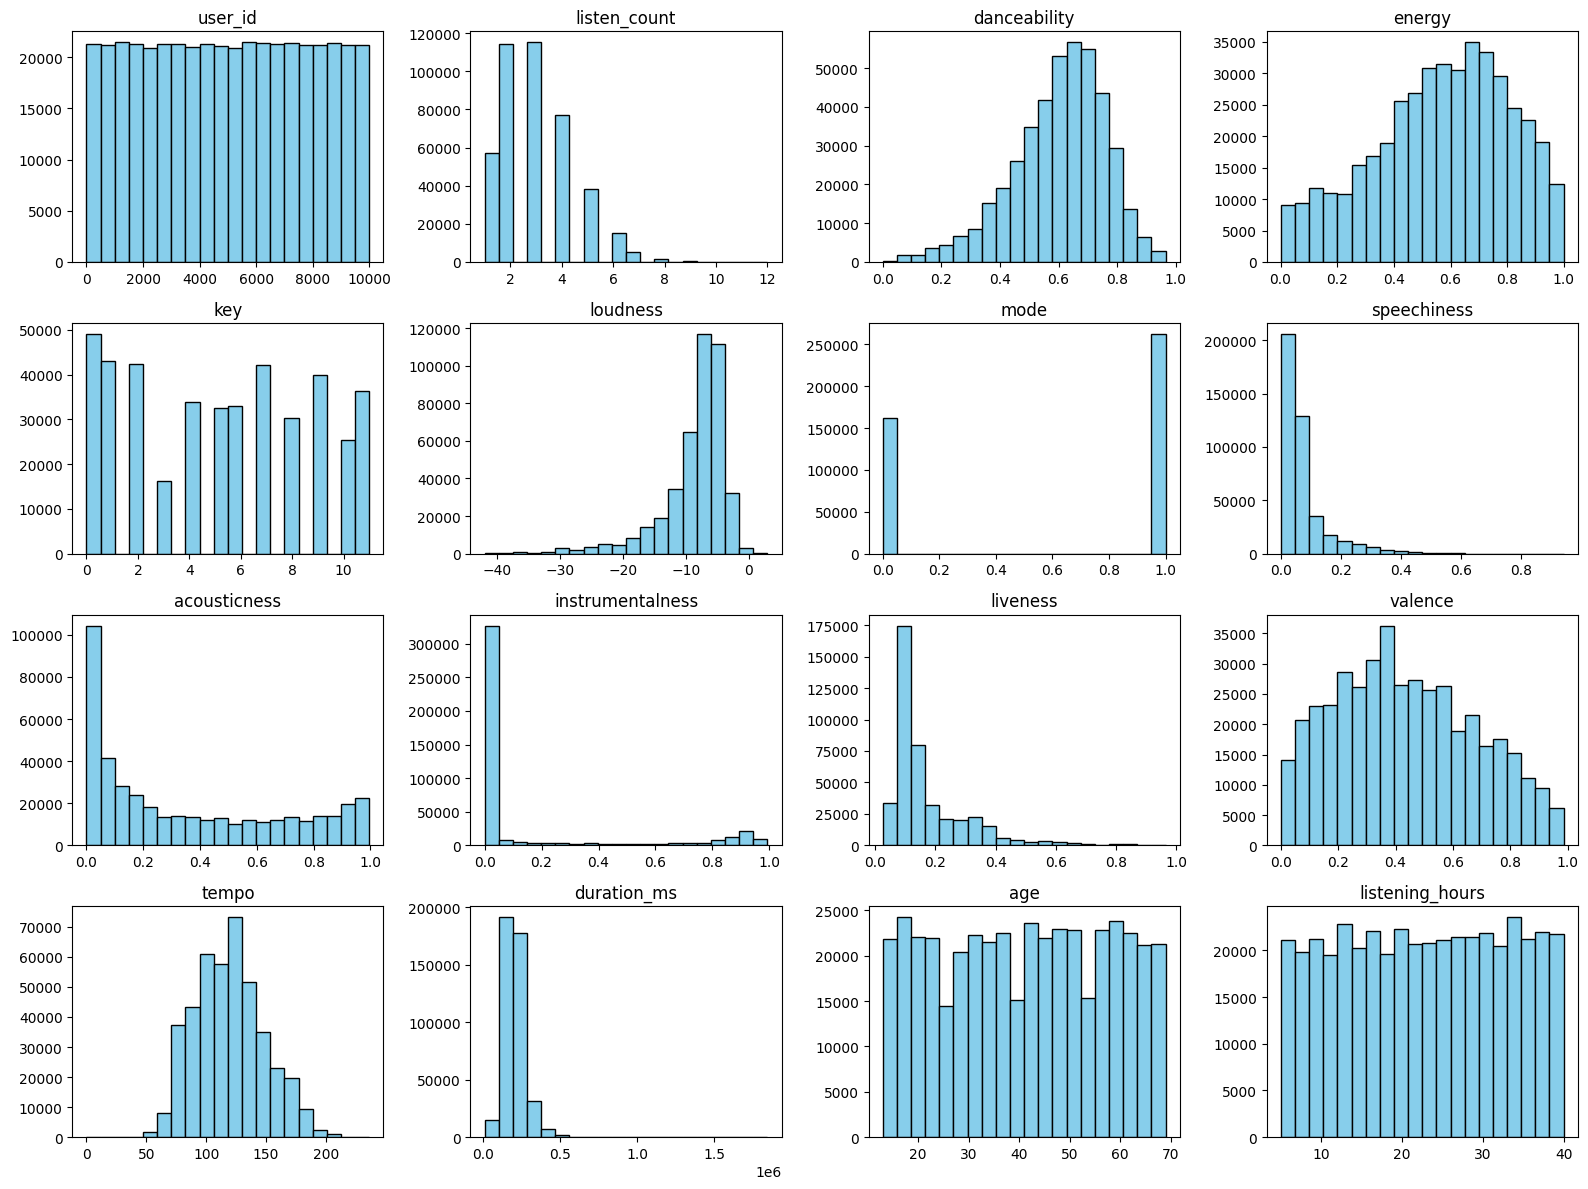

In [15]:
# Analyzing numerical variables : histograms

numerical_cols = unbiased_final_dataset.select_dtypes(include='number').columns

n = len(numerical_cols)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(unbiased_final_dataset[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

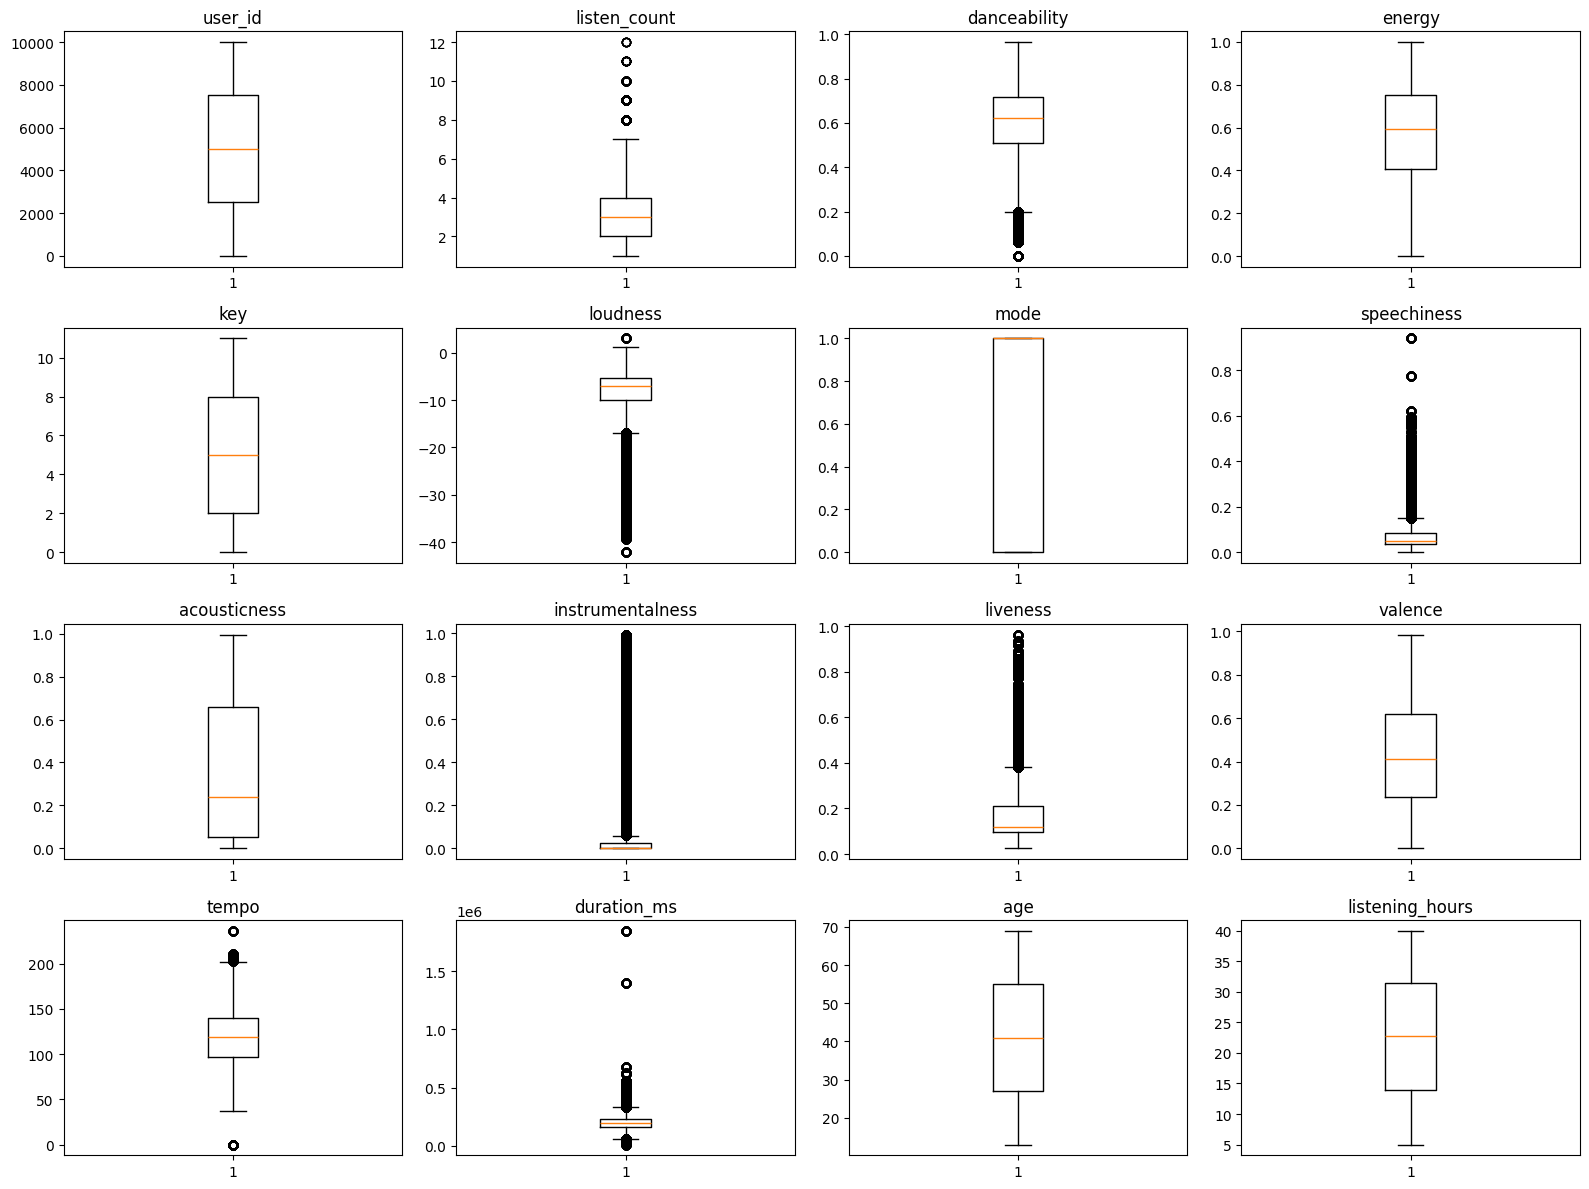

In [16]:
# Analyzing numerical variables : boxplots

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(unbiased_final_dataset[col].dropna(), vert=True)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

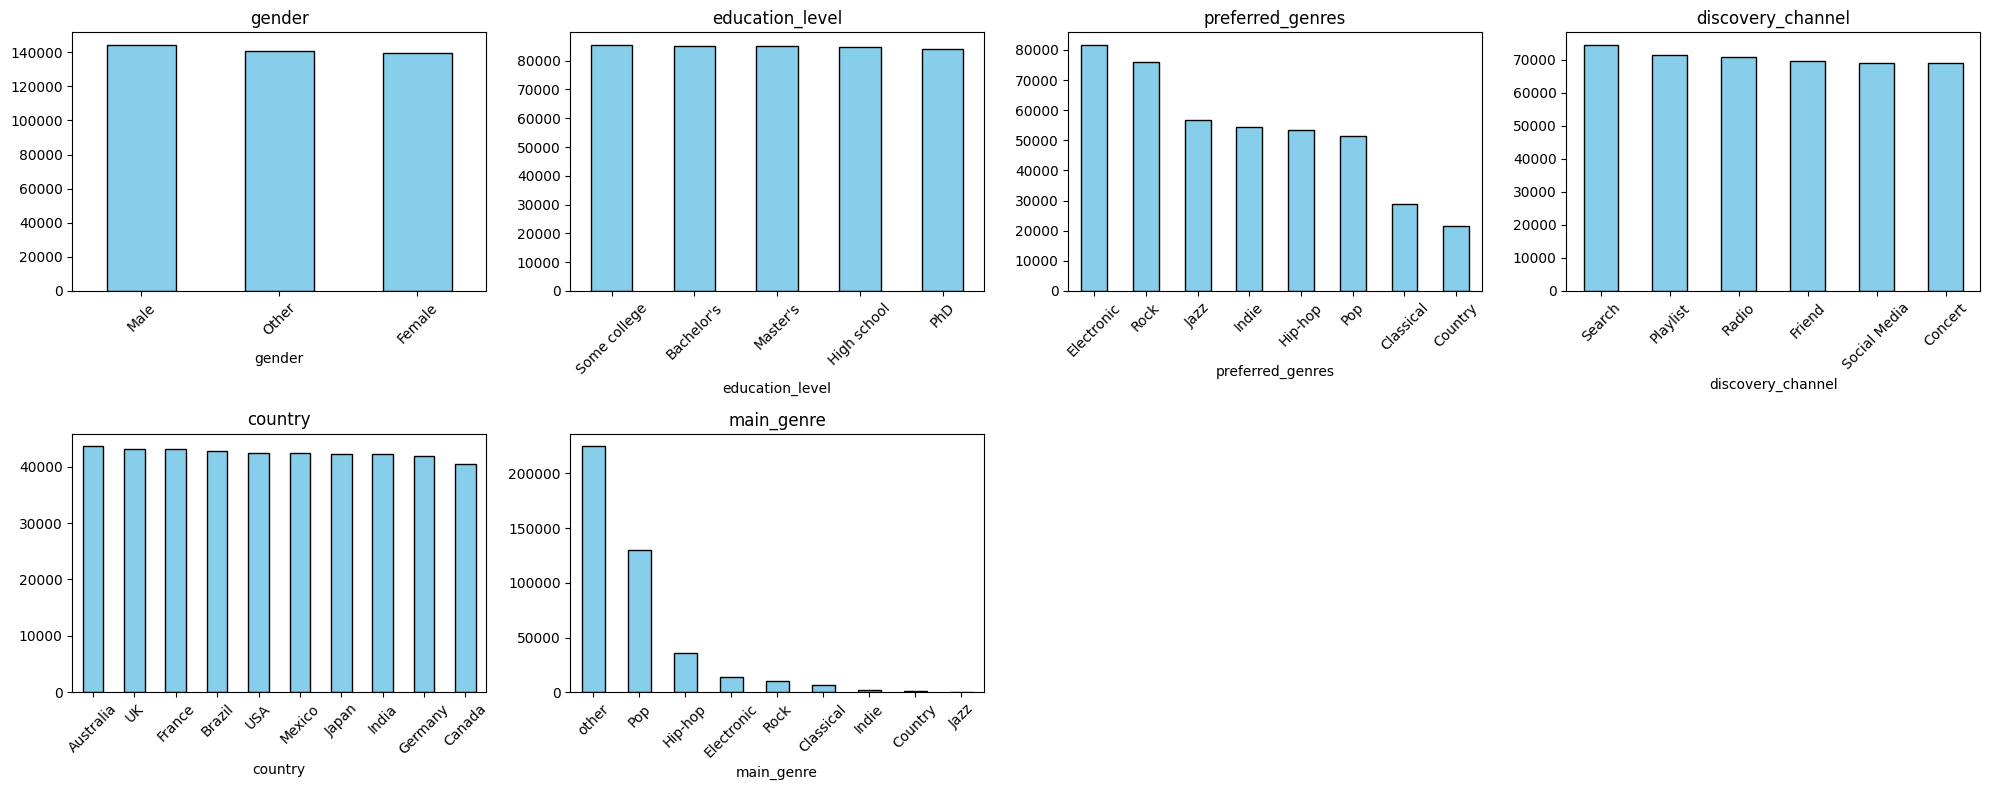

In [17]:
# Analyzing categorical variables : barplots

cat_vars = ['gender','education_level','preferred_genres','discovery_channel','country','main_genre']

cat_vars = [col for col in cat_vars if col in unbiased_final_dataset.columns]
cols = 4
n = len(cat_vars)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    counts = unbiased_final_dataset[col].value_counts(dropna=False)
    counts.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
# Bivariate analysis : categorical variables

table_pct = pd.crosstab(unbiased_final_dataset['education_level'], unbiased_final_dataset['preferred_genres'], normalize='index') * 100
table_pct.round(1)

preferred_genres,Classical,Country,Electronic,Hip-hop,Indie,Jazz,Pop,Rock
education_level,,,,,,,,
Bachelor's,6.8,5.1,19.4,12.6,12.6,13.5,12.2,17.8
High school,6.8,5.0,19.2,12.6,12.8,13.5,12.0,18.2
Master's,7.0,5.2,19.3,12.6,12.8,13.4,12.1,17.7
PhD,6.8,5.0,19.4,12.5,12.9,13.4,12.4,17.7
Some college,6.8,5.1,19.0,12.8,12.9,13.2,12.0,18.0


In [19]:
table_pct = pd.crosstab(unbiased_final_dataset['education_level'], unbiased_final_dataset['country'], normalize='index') * 100
table_pct.round(1)

country,Australia,Brazil,Canada,France,Germany,India,Japan,Mexico,UK,USA
education_level,,,,,,,,,,
Bachelor's,10.4,11.2,9.7,9.7,9.8,11.2,9.8,10.4,9.0,8.9
High school,10.6,10.2,9.4,9.6,9.9,10.6,9.0,10.2,10.5,10.1
Master's,10.1,9.6,9.4,11.6,9.0,8.4,10.5,9.2,11.7,10.3
PhD,9.4,10.0,9.6,9.9,10.8,10.4,10.0,10.6,9.6,9.7
Some college,10.9,9.5,9.6,10.0,9.9,9.2,10.4,9.6,10.0,10.9


In [20]:
table_pct = pd.crosstab(unbiased_final_dataset['education_level'], unbiased_final_dataset['discovery_channel'], normalize='index') * 100
table_pct.round(1)

discovery_channel,Concert,Friend,Playlist,Radio,Search,Social Media
education_level,,,,,,
Bachelor's,16.1,15.9,16.6,16.6,18.5,16.3
High school,14.7,16.3,18.3,17.2,17.9,15.7
Master's,16.4,16.4,16.5,17.0,17.2,16.4
PhD,16.9,17.5,16.1,15.8,17.0,16.6
Some college,17.1,15.9,16.7,16.8,17.2,16.4


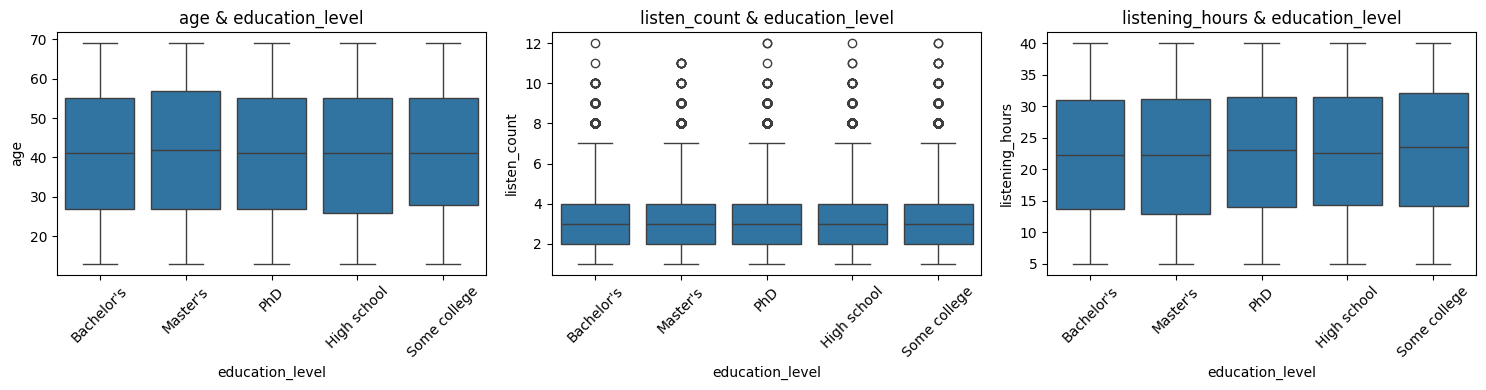

<Figure size 640x480 with 0 Axes>

In [21]:
# Bivariate analysis : education level vs numerical variables

plots = [
    ('education_level', 'age'),
    ('education_level', 'listen_count'),
    ('education_level', 'listening_hours'),
]

cols = 3
n = len(plots)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, (cat_col, num_col) in enumerate(plots):
    sns.boxplot(x=cat_col, y=num_col, data=unbiased_final_dataset, ax=axes[i])
    axes[i].set_title(f"{num_col} & {cat_col}")
    axes[i].tick_params(axis='x', rotation=45)

# Supprimer les axes vides si besoin
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

for i, (cat_col, num_col) in enumerate(plots):
    sns.boxplot(x=cat_col, y=num_col, data=unbiased_final_dataset, ax=axes[i])
    axes[i].set_title(f"{num_col} & {cat_col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Biased dataset

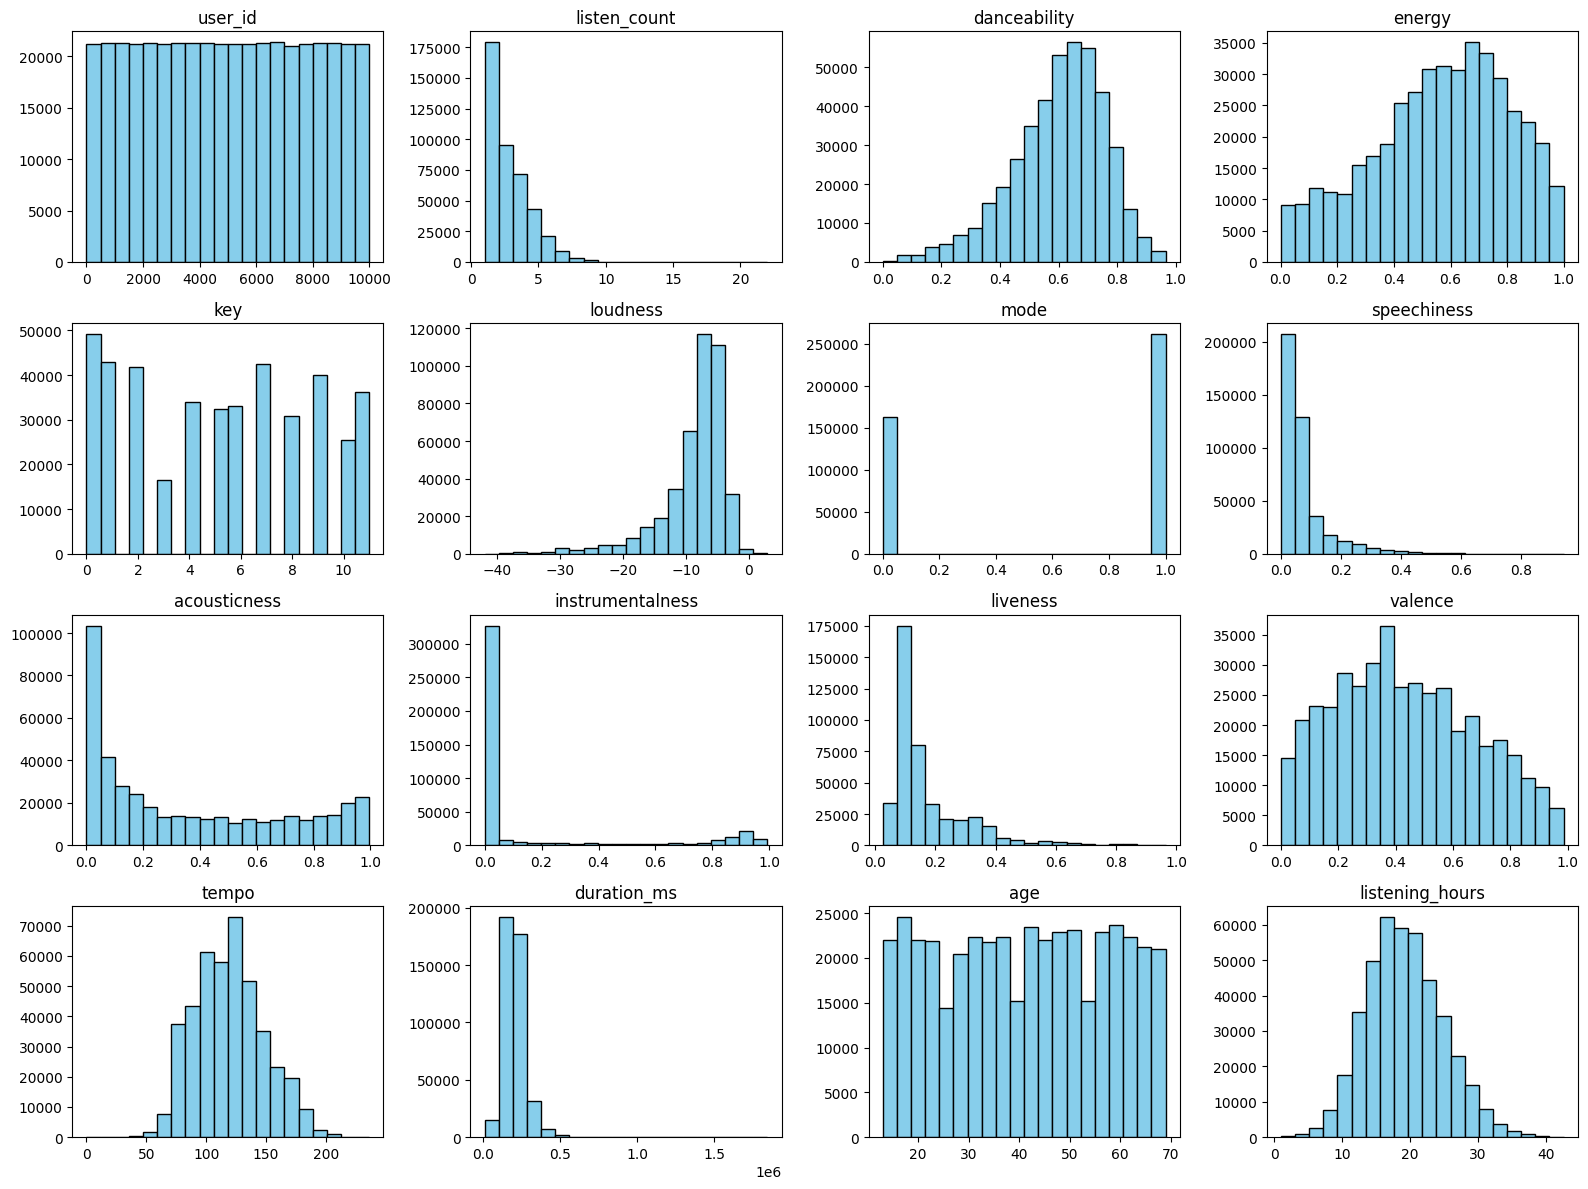

In [22]:
# Analyzing numerical variables : histograms

numerical_cols = biased_final_dataset.select_dtypes(include='number').columns

n = len(numerical_cols)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(biased_final_dataset[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

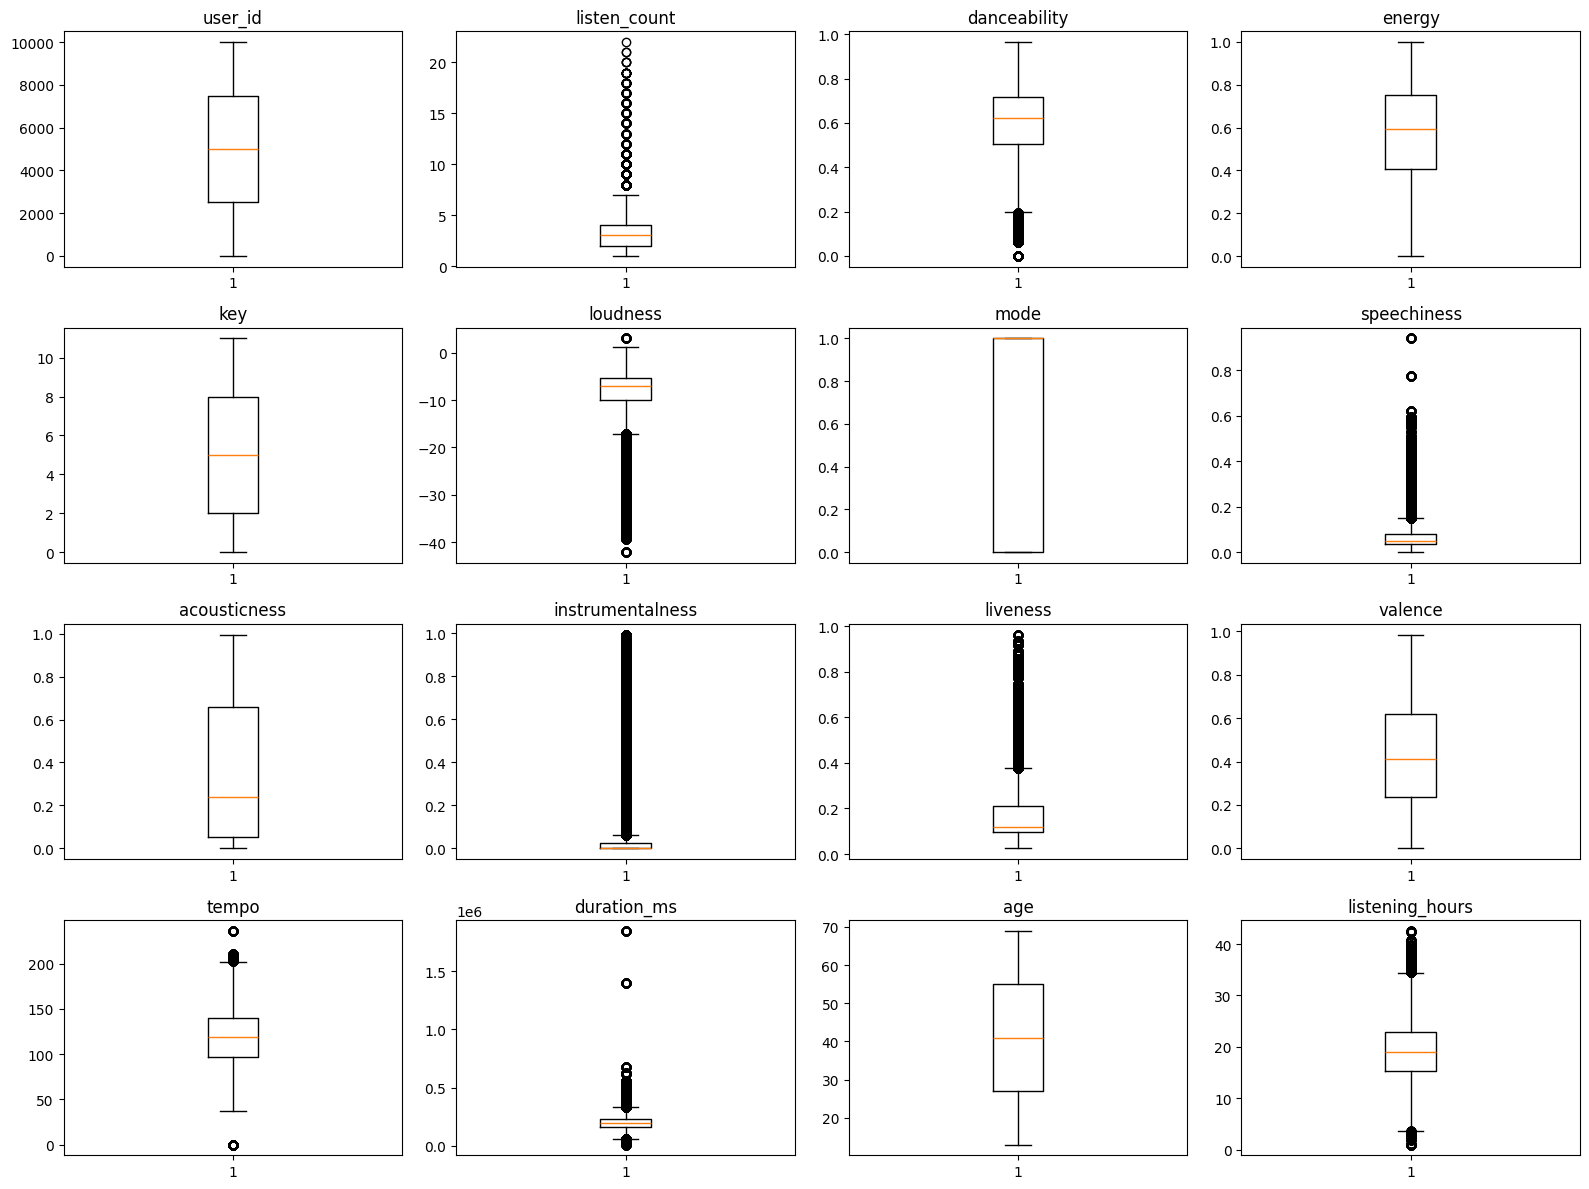

In [23]:
# Analyzing numerical variables : boxplots

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(biased_final_dataset[col].dropna(), vert=True)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

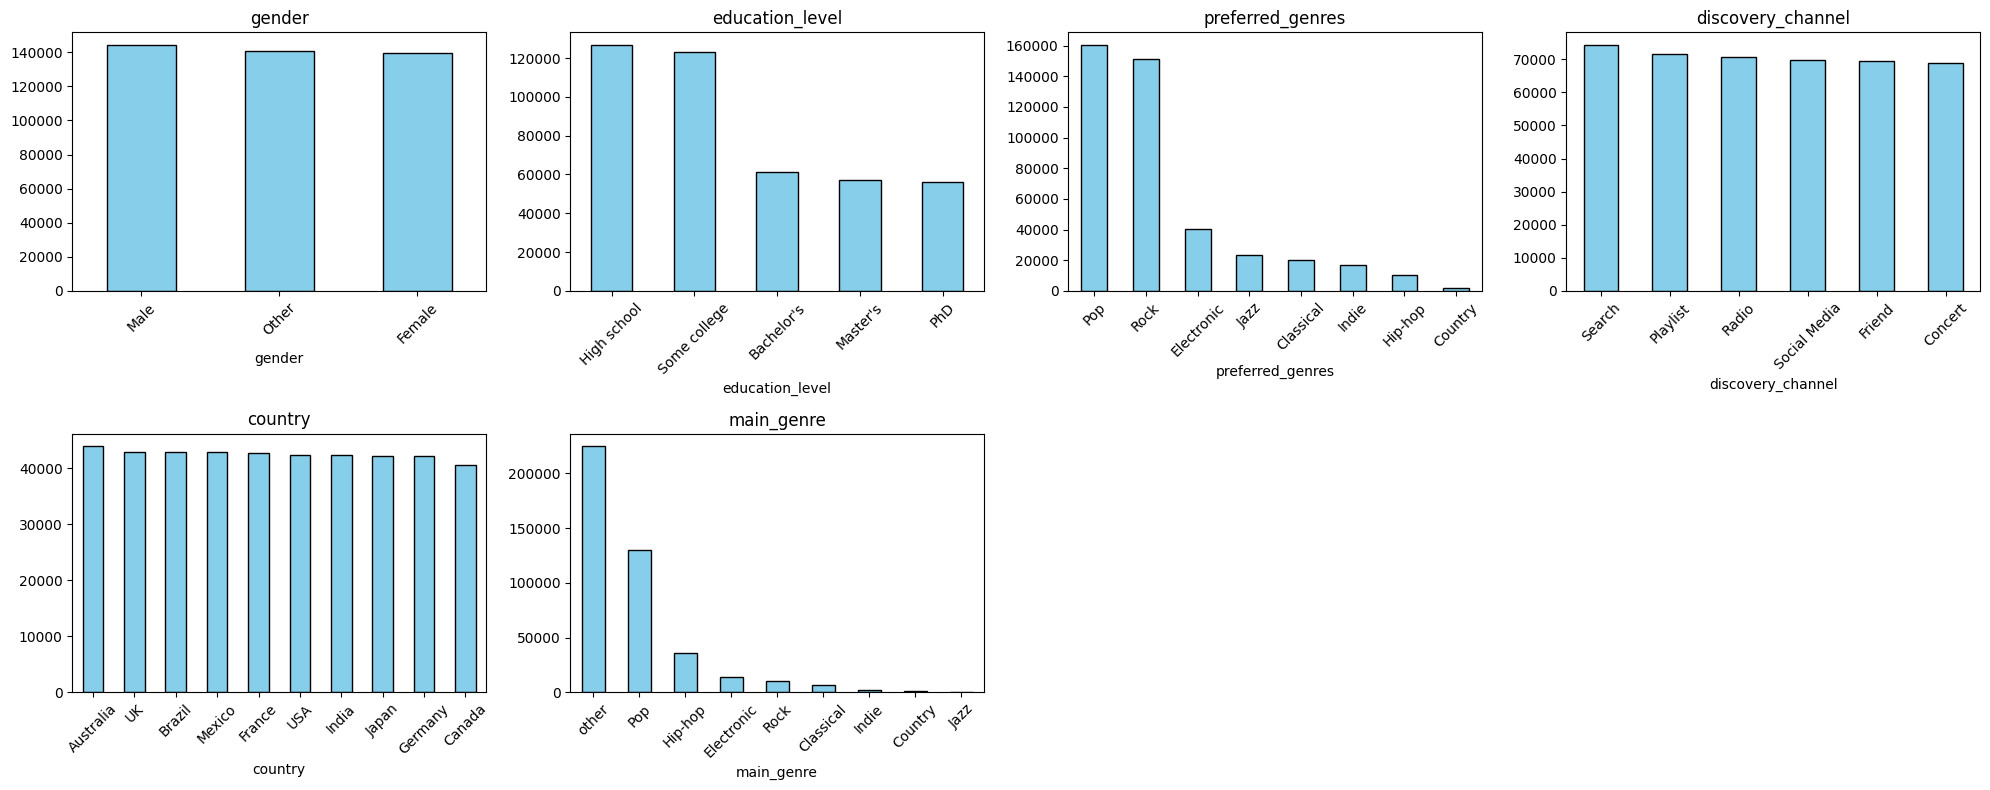

In [24]:
# Analyzing categorical variables : barplots

cat_vars = ['gender','education_level','preferred_genres','discovery_channel','country','main_genre']

cat_vars = [col for col in cat_vars if col in biased_final_dataset.columns]
cols = 4
n = len(cat_vars)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    counts = biased_final_dataset[col].value_counts(dropna=False)
    counts.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [25]:
# Bivariate analysis : categorical variables
table_pct = pd.crosstab(biased_final_dataset['education_level'], biased_final_dataset['preferred_genres'], normalize='index') * 100
table_pct.round(1)

preferred_genres,Classical,Country,Electronic,Hip-hop,Indie,Jazz,Pop,Rock
education_level,,,,,,,,
Bachelor's,0.9,0.6,30.9,1.6,1.3,1.7,32.1,30.9
High school,0.4,0.1,1.1,2.9,0.3,0.9,48.0,46.1
Master's,1.6,1.0,31.5,1.5,0.5,1.8,31.3,30.9
PhD,31.3,0.9,1.4,1.5,27.1,33.6,2.5,1.8
Some college,0.5,0.3,1.0,3.1,0.2,0.9,49.2,44.8


In [26]:
table_pct = pd.crosstab(biased_final_dataset['education_level'], biased_final_dataset['country'], normalize='index') * 100
table_pct.round(1)

country,Australia,Brazil,Canada,France,Germany,India,Japan,Mexico,UK,USA
education_level,,,,,,,,,,
Bachelor's,10.4,11.0,10.3,9.5,9.4,9.3,10.7,9.4,10.5,9.6
High school,10.0,10.6,9.3,9.8,9.0,10.6,9.2,10.1,11.2,10.4
Master's,10.6,9.4,9.8,9.6,11.1,10.0,9.8,10.1,9.1,10.4
PhD,10.0,11.1,8.6,10.2,10.9,9.6,11.2,9.7,9.3,9.4
Some college,10.8,9.0,9.8,10.6,10.1,9.8,9.7,10.6,9.7,9.7


In [ ]:
table_pct = pd.crosstab(biased_final_dataset['education_level'], biased_final_dataset['discovery_channel'], normalize='index') * 100
table_pct.round(1)

discovery_channel,Concert,Friend,Playlist,Radio,Search,Social Media
education_level,,,,,,
Bachelor's,14.9,17.7,18.4,17.2,16.7,15.1
High school,16.5,16.6,16.4,17.3,16.6,16.5
Master's,16.8,17.8,16.1,15.7,17.8,16.0
PhD,15.9,14.2,16.7,17.5,19.2,16.6
Some college,16.3,15.9,17.1,15.8,18.0,17.0


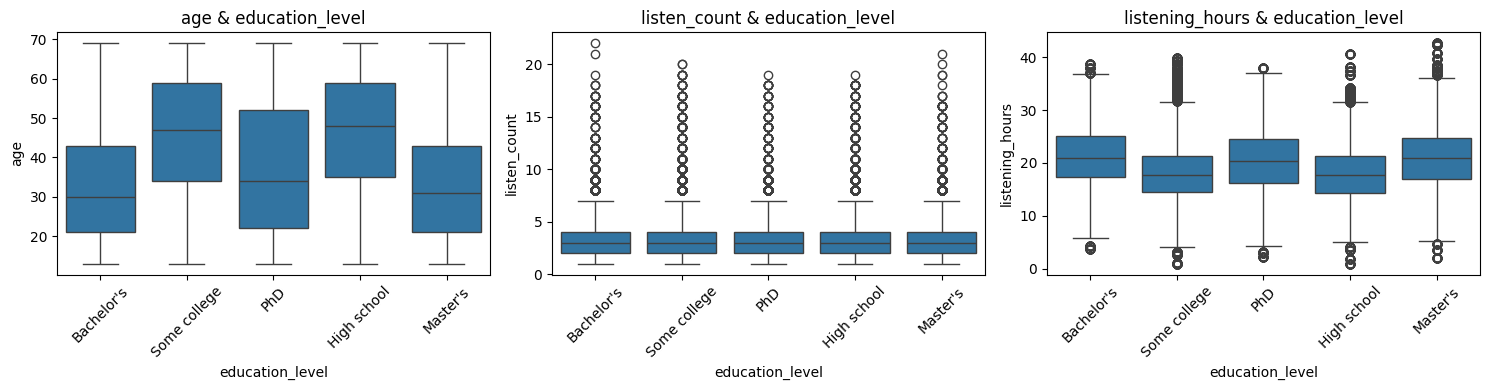

<Figure size 640x480 with 0 Axes>

In [27]:
# Bivariate analysis : education level vs numerical variables

plots = [
    ('education_level', 'age'),
    ('education_level', 'listen_count'),
    ('education_level', 'listening_hours'),
]

cols = 3
n = len(plots)
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, (cat_col, num_col) in enumerate(plots):
    sns.boxplot(x=cat_col, y=num_col, data=biased_final_dataset, ax=axes[i])
    axes[i].set_title(f"{num_col} & {cat_col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

for i, (cat_col, num_col) in enumerate(plots):
    sns.boxplot(x=cat_col, y=num_col, data=biased_final_dataset, ax=axes[i])
    axes[i].set_title(f"{num_col} & {cat_col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Part 6 : Data Preprocessing

##### Normalization: Make numerical data comparable by scaling them to the same range

In [28]:
scaler = StandardScaler()
numerical_features = ['danceability', 'energy', 'key', 'loudness', 'mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo','listening_hours','duration_ms','listen_count']
unbiased_final_dataset[numerical_features] = scaler.fit_transform(unbiased_final_dataset[numerical_features])
biased_final_dataset[numerical_features] = scaler.fit_transform(biased_final_dataset[numerical_features])

##### Encoding: Convert text categories into numbers so the model can understand them


In [29]:
cols_to_encode = ['favorite_artist', 'discovery_channel', 'country', 'gender', 'education_level','preferred_genres','track_id','main_genre']

label_encoders = {}
mappings = {}

for col in cols_to_encode:
    le = LabelEncoder()
    biased_final_dataset[col + '_encoded'] = le.fit_transform(biased_final_dataset[col].astype(str))
    label_encoders[col] = le
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

for col in cols_to_encode:
    unbiased_final_dataset[col + '_encoded'] = label_encoders[col].transform(unbiased_final_dataset[col].astype(str))

for col, mapping in mappings.items():
    print(f"Mapping pour '{col}':")
    print(mapping)
    print()

Mapping pour 'favorite_artist':
{'$uicideboy$': np.int64(0), 'AC/DC': np.int64(1), 'Adele': np.int64(2), 'Arctic Monkeys': np.int64(3), 'Ariana Grande': np.int64(4), 'Avicii': np.int64(5), 'Billie Eilish': np.int64(6), 'Britney Spears': np.int64(7), 'Calvin Harris': np.int64(8), 'Carrie Underwood': np.int64(9), 'Coldplay': np.int64(10), 'Dan + Shay': np.int64(11), 'David Guetta': np.int64(12), 'Deadmau5': np.int64(13), 'Drake': np.int64(14), 'Dua Lipa': np.int64(15), 'Ed Sheeran': np.int64(16), 'Eminem': np.int64(17), 'Florence + The Machine': np.int64(18), 'Foo Fighters': np.int64(19), 'Foster The People': np.int64(20), 'Green Day': np.int64(21), 'Hans Zimmer': np.int64(22), 'Herbie Hancock': np.int64(23), 'Imagine Dragons': np.int64(24), 'Johannes Brahms': np.int64(25), 'John Coltrane': np.int64(26), 'Justin Bieber': np.int64(27), 'Kacey Musgraves': np.int64(28), 'Kendrick Lamar': np.int64(29), 'Kygo': np.int64(30), 'Lauv': np.int64(31), 'Lil Nas X': np.int64(32), 'Linkin Park': np.i

In [30]:
unbiased_final_dataset = unbiased_final_dataset[unbiased_final_dataset['main_genre'] != 'other']
biased_final_dataset = biased_final_dataset[biased_final_dataset['main_genre'] != 'other']

## Part 7 : Supervised classification (preferred_genre)

### Unbiased dataset

CV accuracy: 0.164 ± 0.004
Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.02      0.03       137
           1       0.00      0.00      0.00       101
           2       0.19      0.31      0.24       383
           3       0.12      0.10      0.11       253
           4       0.14      0.10      0.12       258
           5       0.14      0.11      0.12       269
           6       0.12      0.09      0.10       242
           7       0.19      0.28      0.23       357

    accuracy                           0.16      2000
   macro avg       0.12      0.13      0.12      2000
weighted avg       0.14      0.16      0.15      2000



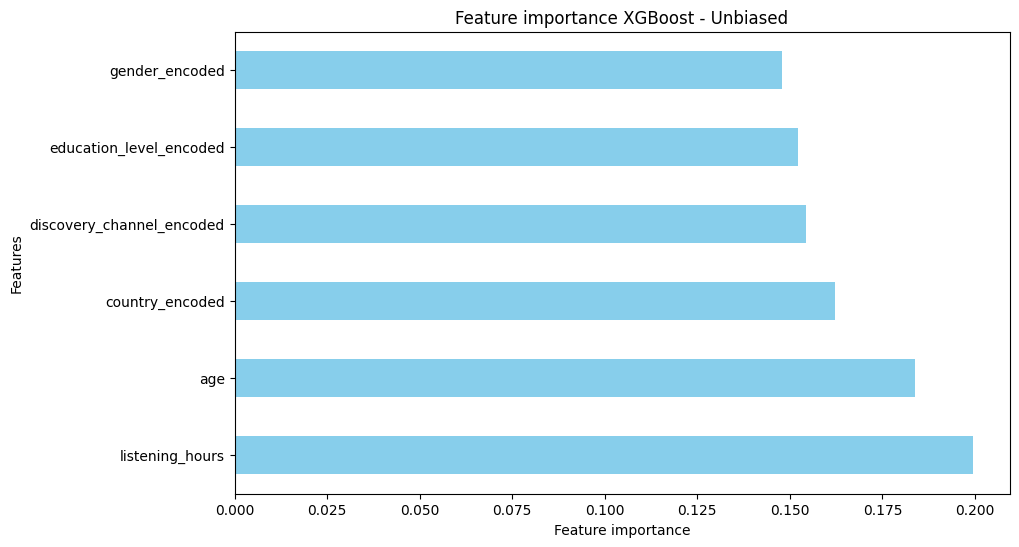

In [31]:
X = unbiased_final_dataset.groupby('user_id')[['age','gender_encoded','education_level_encoded','listening_hours','discovery_channel_encoded','country_encoded']].first()
y = unbiased_final_dataset.groupby('user_id')['preferred_genres_encoded'].first()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost
unbiased_xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Fit the model
unbiased_xgb_model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(unbiased_xgb_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Accuracy metrics
y_pred = unbiased_xgb_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot fature importances
importances = pd.Series(unbiased_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='barh', color='skyblue')
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.title("Feature importance XGBoost - Unbiased")
plt.show()

### Biased dataset

CV accuracy: 0.410 ± 0.014
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.26      0.26        95
           1       0.00      0.00      0.00        10
           2       0.33      0.27      0.30       190
           3       0.00      0.00      0.00        48
           4       0.21      0.17      0.19        80
           5       0.37      0.37      0.37       109
           6       0.46      0.51      0.48       756
           7       0.43      0.45      0.44       712

    accuracy                           0.41      2000
   macro avg       0.26      0.25      0.25      2000
weighted avg       0.40      0.41      0.41      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


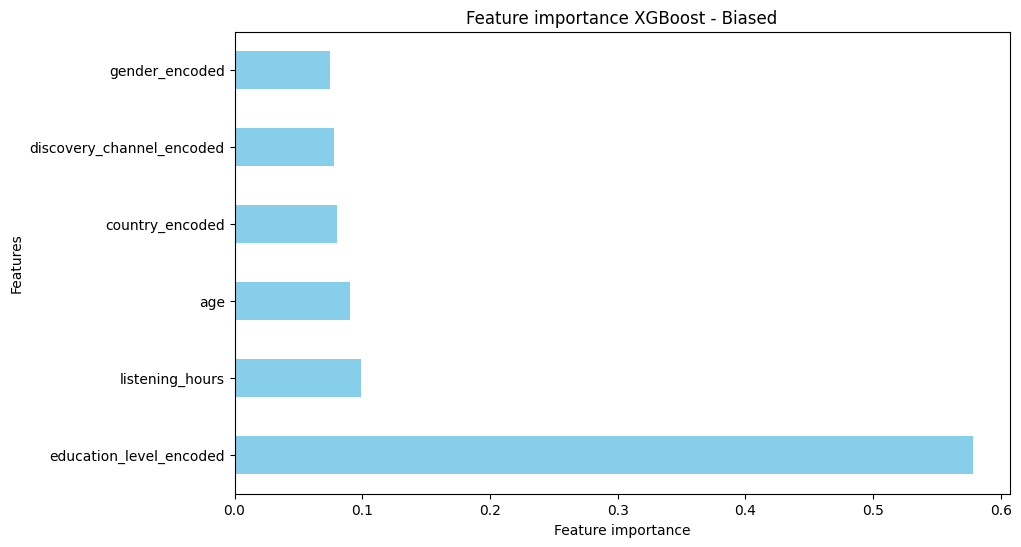

In [32]:
X = biased_final_dataset.groupby('user_id')[['age','gender_encoded','education_level_encoded','listening_hours','discovery_channel_encoded','country_encoded']].first()
y = biased_final_dataset.groupby('user_id')['preferred_genres_encoded'].first()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost
biased_xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Fit the model
biased_xgb_model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(biased_xgb_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Accuracy metrics
y_pred = biased_xgb_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot fature importances
importances = pd.Series(biased_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='barh', color='skyblue')
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.title("Feature importance XGBoost - Biased")
plt.show()

## Part 9 : Recommendation system

### Unbiased dataset

In [33]:
def hybrid_music_recommendation_verbose(user_features, user_id, track_dataset, unbiased_xgb_model, label_encoders, top_n=10, alpha=0.6):

    # Step 1: Predict user preferred genre
    feature_names = ['age', 'gender_encoded', 'education_level_encoded', 'listening_hours', 'discovery_channel_encoded', 'country_encoded']
    user_features_df = pd.DataFrame([user_features], columns=feature_names)

    predicted_genre_encoded = unbiased_xgb_model.predict(user_features_df)[0]
    predicted_genre_proba = unbiased_xgb_model.predict_proba(user_features_df)[0]

    predicted_genre_name = label_encoders['preferred_genres'].inverse_transform([predicted_genre_encoded])[0]

    print(f"\nStep 1: Predicted genre = {predicted_genre_name} (confidence {predicted_genre_proba[predicted_genre_encoded]:.2f})\n")

    # Step 2: Filter tracks by predicted genre
    candidate_tracks = track_dataset[track_dataset['preferred_genres_encoded'] == predicted_genre_encoded].copy()
    print(f"Step 2: {len(candidate_tracks)} candidate tracks after filtering by genre '{predicted_genre_name}'\n")

   # Step 3: Content-based scoring
    content_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

    if user_id in track_dataset['user_id'].values:
        user_tracks = track_dataset[(track_dataset['user_id'] == user_id) & (track_dataset['listen_count'] > 1)]

        if not user_tracks.empty:
            user_profile_vector = user_tracks[content_features].mean().values.reshape(1, -1)
        else:
            user_profile_vector = track_dataset[content_features].mean().values.reshape(1, -1)
    else:
        user_profile_vector = track_dataset[content_features].mean().values.reshape(1, -1)

    track_features_grouped = candidate_tracks.groupby('track_id_encoded')[content_features].mean()
    content_scores = cosine_similarity(track_features_grouped.values, user_profile_vector).flatten()

    candidate_tracks = candidate_tracks.merge(
        pd.DataFrame({'track_id_encoded': track_features_grouped.index, 'content_score': content_scores}),
        on='track_id_encoded',
        how='left'
    )

    print("Step 3: Content-based score calculated for each track:")
    print(candidate_tracks[['track_id_encoded', 'artist_name', 'content_score']].head(), "\n")

    # Step 4: Collaborative filtering
    user_item_matrix = track_dataset.pivot_table(
        index='user_id', columns='track_id_encoded', values='listen_count'
    ).fillna(0)

    if user_id in user_item_matrix.index:
        user_item_matrix_norm = normalize(user_item_matrix, norm='l2', axis=1)

        similarity_matrix = cosine_similarity(user_item_matrix_norm)
        similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

        top_k = 20
        similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(top_k)

        collaborative_scores = {}
        for track_id in user_item_matrix.columns:
            score = np.dot(similar_users.values, user_item_matrix.loc[similar_users.index, track_id]) / (similar_users.sum() + 1e-9)
            collaborative_scores[track_id] = score

        collab_df = pd.DataFrame(list(collaborative_scores.items()), columns=['track_id_encoded', 'collab_score'])
        candidate_tracks = candidate_tracks.merge(collab_df, on='track_id_encoded', how='left')
        candidate_tracks['collab_score'] = candidate_tracks['collab_score'].fillna(0)
    else:
        candidate_tracks['collab_score'] = 0

    print("Step 4: Collaborative score calculated for each track:")
    print(candidate_tracks[['track_id_encoded', 'artist_name', 'collab_score']].head(), "\n")

    # Step 5: Final hybrid score
    candidate_tracks['final_score'] = alpha * candidate_tracks['content_score'] + (1 - alpha) * candidate_tracks['collab_score']

    final_result = (candidate_tracks.sort_values(by='final_score', ascending=False)
                    .drop_duplicates(subset=['track_id_encoded'])
                    .head(top_n))

    final_result['track_genre'] = final_result['main_genre']
    final_result['track_id'] = final_result['track_id_encoded']

    print("Step 5: Final hybrid score and top tracks:")
    print(final_result[['track_id', 'artist_name', 'track_genre', 'content_score', 'collab_score', 'final_score']])

    return final_result

user_id_example = int(input("Enter your user ID: "))
user_row = unbiased_final_dataset[unbiased_final_dataset['user_id'] == user_id_example]

if user_row.empty:
    print(f"No data found for user {user_id_example}")
else:
    user_features = [
        user_row['age'].values[0],
        user_row['gender_encoded'].values[0],
        user_row['education_level_encoded'].values[0],
        user_row['listening_hours'].values[0],
        user_row['discovery_channel_encoded'].values[0],
        user_row['country_encoded'].values[0]
    ]

    top_tracks = hybrid_music_recommendation_verbose(
        user_features=user_features,
        user_id=user_id_example,
        track_dataset=unbiased_final_dataset,
        unbiased_xgb_model=unbiased_xgb_model,
        label_encoders=label_encoders,
        top_n=10,
        alpha=0.6
    )

Enter your user ID: 1

Step 1: Predicted genre = Pop (confidence 0.37)

Step 2: 24248 candidate tracks after filtering by genre 'Pop'

Step 3: Content-based score calculated for each track:
   track_id_encoded            artist_name  content_score
0               792             Jonas Blue       0.086867
1              1517                Tove Lo       0.163770
2              3338  Johann Sebastian Bach      -0.256241
3              3370                 Jack Ü      -0.076042
4              2571             flora cash      -0.251772 

Step 4: Collaborative score calculated for each track:
   track_id_encoded            artist_name  collab_score
0               792             Jonas Blue           0.0
1              1517                Tove Lo           0.0
2              3338  Johann Sebastian Bach           0.0
3              3370                 Jack Ü           0.0
4              2571             flora cash           0.0 

Step 5: Final hybrid score and top tracks:
       track_id   

### Biased dataset

In [34]:
def hybrid_music_recommendation_verbose(user_features, user_id, track_dataset, biased_xgb_model, label_encoders, top_n=10, alpha=0.6):

    # Step 1: Predict user preferred genre
    feature_names = ['age', 'gender_encoded', 'education_level_encoded', 'listening_hours', 'discovery_channel_encoded', 'country_encoded']
    user_features_df = pd.DataFrame([user_features], columns=feature_names)

    predicted_genre_encoded = biased_xgb_model.predict(user_features_df)[0]
    predicted_genre_proba = biased_xgb_model.predict_proba(user_features_df)[0]

    predicted_genre_name = label_encoders['preferred_genres'].inverse_transform([predicted_genre_encoded])[0]

    print(f"\nStep 1: Predicted genre = {predicted_genre_name} (confidence {predicted_genre_proba[predicted_genre_encoded]:.2f})\n")

    # Step 2: Filter tracks by predicted genre
    candidate_tracks = track_dataset[track_dataset['preferred_genres_encoded'] == predicted_genre_encoded].copy()
    print(f"Step 2: {len(candidate_tracks)} candidate tracks after filtering by genre '{predicted_genre_name}'\n")

   # Step 3: Content-based scoring
    content_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

    if user_id in track_dataset['user_id'].values:
        user_tracks = track_dataset[(track_dataset['user_id'] == user_id) & (track_dataset['listen_count'] > 1)]

        if not user_tracks.empty:
            user_profile_vector = user_tracks[content_features].mean().values.reshape(1, -1)
        else:
            user_profile_vector = track_dataset[content_features].mean().values.reshape(1, -1)
    else:
        user_profile_vector = track_dataset[content_features].mean().values.reshape(1, -1)

    track_features_grouped = candidate_tracks.groupby('track_id_encoded')[content_features].mean()
    content_scores = cosine_similarity(track_features_grouped.values, user_profile_vector).flatten()

    candidate_tracks = candidate_tracks.merge(
        pd.DataFrame({'track_id_encoded': track_features_grouped.index, 'content_score': content_scores}),
        on='track_id_encoded',
        how='left'
    )

    print("Step 3: Content-based score calculated for each track:")
    print(candidate_tracks[['track_id_encoded', 'artist_name', 'content_score']].head(), "\n")

    # Step 4: Collaborative filtering
    user_item_matrix = track_dataset.pivot_table(
        index='user_id', columns='track_id_encoded', values='listen_count'
    ).fillna(0)

    if user_id in user_item_matrix.index:
        user_item_matrix_norm = normalize(user_item_matrix, norm='l2', axis=1)

        similarity_matrix = cosine_similarity(user_item_matrix_norm)
        similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

        top_k = 20
        similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(top_k)

        collaborative_scores = {}
        for track_id in user_item_matrix.columns:
            score = np.dot(similar_users.values, user_item_matrix.loc[similar_users.index, track_id]) / (similar_users.sum() + 1e-9)
            collaborative_scores[track_id] = score

        collab_df = pd.DataFrame(list(collaborative_scores.items()), columns=['track_id_encoded', 'collab_score'])
        candidate_tracks = candidate_tracks.merge(collab_df, on='track_id_encoded', how='left')
        candidate_tracks['collab_score'] = candidate_tracks['collab_score'].fillna(0)
    else:
        candidate_tracks['collab_score'] = 0

    print("Step 4: Collaborative score calculated for each track:")
    print(candidate_tracks[['track_id_encoded', 'artist_name', 'collab_score']].head(), "\n")

    # Step 5: Final hybrid score
    candidate_tracks['final_score'] = alpha * candidate_tracks['content_score'] + (1 - alpha) * candidate_tracks['collab_score']

    final_result = (candidate_tracks.sort_values(by='final_score', ascending=False)
                    .drop_duplicates(subset=['track_id_encoded'])
                    .head(top_n))

    final_result['track_genre'] = final_result['main_genre']
    final_result['track_id'] = final_result['track_id_encoded']

    print("Step 5: Final hybrid score and top tracks:")
    print(final_result[['track_id', 'artist_name', 'track_genre', 'content_score', 'collab_score', 'final_score']])

    return final_result

user_id_example = int(input("Enter your user ID: "))
user_row = unbiased_final_dataset[unbiased_final_dataset['user_id'] == user_id_example]

if user_row.empty:
    print(f"No data found for user {user_id_example}")
else:
    user_features = [
        user_row['age'].values[0],
        user_row['gender_encoded'].values[0],
        user_row['education_level_encoded'].values[0],
        user_row['listening_hours'].values[0],
        user_row['discovery_channel_encoded'].values[0],
        user_row['country_encoded'].values[0]
    ]

    top_tracks = hybrid_music_recommendation_verbose(
        user_features=user_features,
        user_id=user_id_example,
        track_dataset=unbiased_final_dataset,
        biased_xgb_model=biased_xgb_model,
        label_encoders=label_encoders,
        top_n=10,
        alpha=0.6
    )

Enter your user ID: 1

Step 1: Predicted genre = Electronic (confidence 0.50)

Step 2: 38082 candidate tracks after filtering by genre 'Electronic'

Step 3: Content-based score calculated for each track:
   track_id_encoded               artist_name  content_score
0              3567              young friend      -0.354653
1              2092              Good Morning      -0.029889
2              3593  High School Musical Cast       0.183340
3              2793           Louis The Child       0.443966
4              2560                 Baby Keem       0.731428 

Step 4: Collaborative score calculated for each track:
   track_id_encoded               artist_name  collab_score
0              3567              young friend     -0.046412
1              2092              Good Morning      0.000000
2              3593  High School Musical Cast      0.000000
3              2793           Louis The Child      0.000000
4              2560                 Baby Keem     -0.000133 

Step 5: Fin

**How it works step-by-step:**

Classification model (tree_model)
- Predicts the user's most likely preferred genre based on their demographic & listening patterns.

Content-based filtering (rf_model)
- Content-based scoring computes each track’s score by averaging its audio features like danceability, energy, and tempo.

Collaborative filtering
- Builds a user-item matrix from listen_count.
- Finds users similar to the target user using cosine similarity.
- Predicts scores for tracks based on what similar users listened to.

Hybrid fusion
- Combines the two scores (content_score and collab_score) using a weight alpha.
- alpha = 0.6 → 60% content-based, 40% collaborative.

Output
- Sorted recommendations

## Part 10 : Model bias analysis

SHAP unbiased

              Unbiased model analysis         

--- SHAP analysis unnbiased model ---


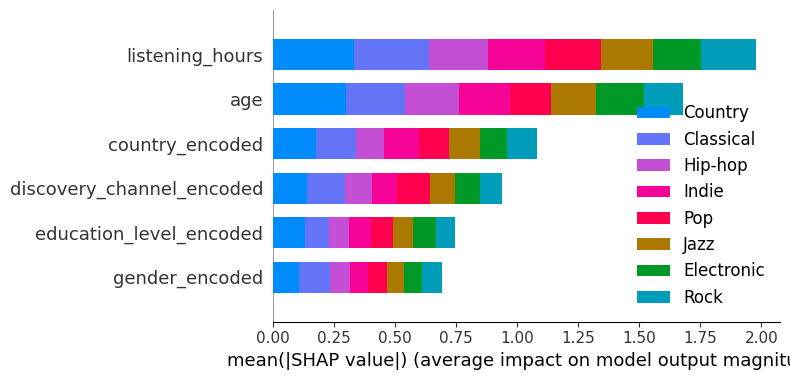

In [35]:
print("==============================================")
print("              Unbiased model analysis         ")
print("==============================================")

feature_names = ['age', 'gender_encoded', 'education_level_encoded', 'listening_hours', 'discovery_channel_encoded', 'country_encoded']

y_unbiased_analysis = unbiased_final_dataset['preferred_genres_encoded']

# SHAP analysis
explainer_unbiased = shap.TreeExplainer(unbiased_xgb_model)
shap_values_unbiased = explainer_unbiased.shap_values(X_test)

print("\n--- SHAP analysis unnbiased model ---")
shap.summary_plot(shap_values_unbiased, X_test, class_names=label_encoders['preferred_genres'].classes_, plot_type="bar")

SHAP biased

            Biased model analysis             

--- SHAP analysis biased model ---


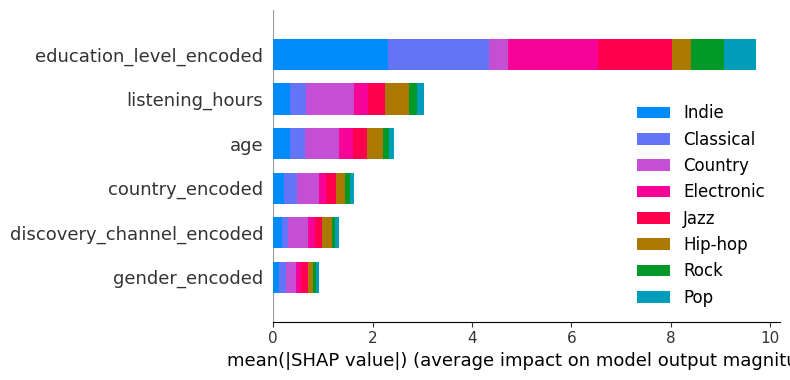

In [36]:
print("==============================================")
print("            Biased model analysis             ")
print("==============================================")

feature_names = ['age', 'gender_encoded', 'education_level_encoded', 'listening_hours', 'discovery_channel_encoded', 'country_encoded']

y_biased_analysis = biased_final_dataset['preferred_genres_encoded']

# SHAP analysis
explainer_biased = shap.TreeExplainer(biased_xgb_model)
shap_values_biased = explainer_biased.shap_values(X_test)

print("\n--- SHAP analysis biased model ---")
shap.summary_plot(shap_values_biased, X_test, class_names=label_encoders['preferred_genres'].classes_, plot_type="bar")

Fairness metrics for unbiased and biased

In [37]:
# ==============================
# Global metric by education
# ==============================

y_pred_unbiased = unbiased_xgb_model.predict(X_test)
y_pred_biased = biased_xgb_model.predict(X_test)

sensitive_feature = X_test['education_level_encoded']

global_metrics = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score
}

# Unbiased
metric_frame_unbiased = MetricFrame(
    metrics=global_metrics,
    y_true=y_test,
    y_pred=y_pred_unbiased,
    sensitive_features=sensitive_feature
)

# Biased
metric_frame_biased = MetricFrame(
    metrics=global_metrics,
    y_true=y_test,
    y_pred=y_pred_biased,
    sensitive_features=sensitive_feature
)

print("\n=== Fairness - Global Metrics by Education Level ===")
print("\nUnbiased model:\n", metric_frame_unbiased.by_group)
print("\nBiased model:\n", metric_frame_biased.by_group)


=== Fairness - Global Metrics by Education Level ===

Unbiased model:
                          Accuracy  Balanced Accuracy
education_level_encoded                             
0                        0.195730           0.112825
1                        0.180488           0.103130
2                        0.190661           0.210492
3                        0.095941           0.144877
4                        0.157986           0.101043

Biased model:
                          Accuracy  Balanced Accuracy
education_level_encoded                             
0                        0.302491           0.136418
1                        0.468293           0.124989
2                        0.354086           0.187314
3                        0.291513           0.114930
4                        0.498264           0.130497


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [38]:
# ==============================
# Selection Rate by music type
# ==============================

genres_to_check = [0, 1, 2]

results = {}

for genre in genres_to_check:
    def is_pred_genre(y_true, y_pred, genre=genre):
        return (y_pred == genre).astype(int)

    metrics = {"Selection Rate": lambda y_true, y_pred: selection_rate(y_true, is_pred_genre(y_true, y_pred, genre))}

    # Unbiased
    frame_unbiased = MetricFrame(
        metrics=metrics,
        y_true=y_test,
        y_pred=y_pred_unbiased,
        sensitive_features=sensitive_feature
    )

    # Biased
    frame_biased = MetricFrame(
        metrics=metrics,
        y_true=y_test,
        y_pred=y_pred_biased,
        sensitive_features=sensitive_feature
    )

    results[genre] = {
        "Unbiased": frame_unbiased.by_group,
        "Biased": frame_biased.by_group
    }

print("\n=== Fairness - Selection Rate by Genre and Education Level ===")
for genre, res in results.items():
    print(f"\n--- Genre {genre} ---")
    print("Unbiased:\n", res["Unbiased"])
    print("Biased:\n", res["Biased"])


=== Fairness - Selection Rate by Genre and Education Level ===

--- Genre 0 ---
Unbiased:
                          Selection Rate
education_level_encoded                
0                              0.021352
1                              0.030894
2                              0.011673
3                              0.029520
4                              0.019097
Biased:
                          Selection Rate
education_level_encoded                
0                              0.000000
1                              0.000000
2                              0.000000
3                              0.350554
4                              0.000000

--- Genre 1 ---
Unbiased:
                          Selection Rate
education_level_encoded                
0                              0.003559
1                              0.011382
2                              0.015564
3                              0.022140
4                              0.031250
Biased:
                       

# Reminder of encoding for educational groups and music genres

In [39]:
df = unbiased_final_dataset

level_education = LabelEncoder()
level_education.fit(df['education_level'])
education_mapping = dict(zip(level_education.classes_, level_education.transform(level_education.classes_)))

print("Level of education")
print(education_mapping)

Level of education
{"Bachelor's": np.int64(0), 'High school': np.int64(1), "Master's": np.int64(2), 'PhD': np.int64(3), 'Some college': np.int64(4)}


In [40]:
df = unbiased_final_dataset

music_genre = LabelEncoder()
music_genre.fit(df['preferred_genres'])
genre_mapping = dict(zip(music_genre.classes_, music_genre.transform(music_genre.classes_)))

print("Music type")
print(genre_mapping)

Music type
{'Classical': np.int64(0), 'Country': np.int64(1), 'Electronic': np.int64(2), 'Hip-hop': np.int64(3), 'Indie': np.int64(4), 'Jazz': np.int64(5), 'Pop': np.int64(6), 'Rock': np.int64(7)}


# Conclusion
